In [1]:
import os, sys, subprocess, fitsio
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import desitarget.mtl
import matplotlib.pyplot as plt
import glob
%matplotlib inline

**Learning goals**

In this notebook you will learn how to:

* Use observational data from DR8 to prepare it for fiberassign.
* Run fiberassign using the files generated above.
* Explore the outputs of fiberassign.

This notebook has been tested against `desi_environment` `master` on November 2019.

This notebook reuses code by S. Bailey https://github.com/desihub/tutorials/blob/master/FiberAssign.ipynb

In [2]:
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign_obs'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)

Paths and filenames with the observational data

In [3]:
paths = {"targets": "/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/", 
         "skies": "/project/projectdirs/desi/target/catalogs/dr8/0.31.0/skies/", 
         "gfas": "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

names = {"targets": "dr7.1-PR372.fits", "skies":"skies-dr8-0.31.0.fits", "gfas": "dr7.1.fits"}

Some more files needed to run fiberassign

In [4]:
mtlfile = os.path.join(workdir, 'mtl.fits')
truthfile = os.path.join(workdir, 'truth.fits')
starfile = os.path.join(workdir, 'std.fits')
targetcutfile = os.path.join(workdir, 'targets.fits') 
skycutfile = os.path.join(workdir, 'sky.fits') 
targetfile = os.path.join(paths["targets"], "targets-{}".format(names["targets"]))
skyfile = os.path.join(paths["skies"], "skies-{}".format(names["skies"]))
gfafile = os.path.join(paths["gfas"], "gfas-{}".format(names["gfas"]))
tilefile = os.path.join(workdir, "tiles.fits")

In [5]:
# tile selection
program = "dark"

tiles = desimodel.io.load_tiles()
bright = tiles['PROGRAM']=='BRIGHT'
    
small = ((tiles['RA']>12) & (tiles['RA']<20) & (tiles['DEC']<1) & (tiles['DEC']>-1))

if program=="bright":
    Table(tiles[(bright)&(small)]).write(tilefile, overwrite=True)
else:
    Table(tiles[(~bright) & (small)]).write(tilefile, overwrite=True)

print("Wrote tiles to {}".format(tilefile))

Wrote tiles to /global/cscratch1/sd/forero/desi/test/fiberassign_obs/tiles.fits


In [6]:
def write_initial_mtl_file(path_to_targets, mtl_file):
    target_files = glob.glob(os.path.join(path_to_targets, "targets*fits"))
    print('target files to read:', len(target_files))
    target_files.sort()
    
    data = fitsio.FITS(target_files[0], 'r')
    target_data = data[1].read(columns=['TARGETID', 'DESI_TARGET', 'MWS_TARGET', 'BGS_TARGET', 'SUBPRIORITY', 'NUMOBS_INIT', 'PRIORITY_INIT', 'RA', 'DEC', 'HPXPIXEL', 'BRICKNAME'])
    data.close()
    for i, i_name in enumerate(target_files[1:]):
        data = fitsio.FITS(i_name, 'r')
        tmp_data = data[1].read(columns=['TARGETID', 'DESI_TARGET', 'MWS_TARGET', 'BGS_TARGET', 'SUBPRIORITY', 'NUMOBS_INIT', 'PRIORITY_INIT', 'RA', 'DEC', 'HPXPIXEL', 'BRICKNAME'])
        target_data = np.hstack((target_data, tmp_data))
        data.close()
        print('reading file', i, len(target_files), len(tmp_data))
    full_mtl = desitarget.mtl.make_mtl(target_data, 'DARK|GRAY')

    ii_subset = (full_mtl['RA']>10) & (full_mtl['RA']<22) & (full_mtl['DEC']>-3) & (full_mtl['DEC']<3)

    print("Writing subsetfile")
    full_mtl[ii_subset].write(mtl_file, overwrite=True)

In [7]:
# write initial Merged Target List (MTL) file
if (not os.path.exists(mtlfile)):
    write_initial_mtl_file(paths["targets"], mtlfile)
    print('Done writing mtl data')

target files to read: 32
reading file 0 32 256289
reading file 1 32 4532582
reading file 2 32 20
reading file 3 32 5003715
reading file 4 32 5584769
reading file 5 32 3907729
reading file 6 32 3946378
reading file 7 32 5699127
reading file 8 32 4382367
reading file 9 32 3507499
reading file 10 32 3440441
reading file 11 32 3427727
reading file 12 32 4618152
reading file 13 32 4678745
reading file 14 32 5015385
reading file 15 32 3453631
reading file 16 32 7537070
reading file 17 32 4531487
reading file 18 32 3953483
reading file 19 32 1567757
reading file 20 32 3873054
reading file 21 32 5267424
reading file 22 32 2020765
reading file 23 32 4596113
reading file 24 32 4776432
reading file 25 32 4457068
reading file 26 32 3957455
reading file 27 32 4262977
reading file 28 32 4789174
reading file 29 32 4479744
reading file 30 32 1100824
INFO:mtl.py:158:make_mtl: 15642760 of 123285320 targets have priority zero, setting N_obs=0.
INFO:mtl.py:189:make_mtl: Done...t=230.6s
Writing subsetfile


Text(0,0.5,'DEC [deg]')

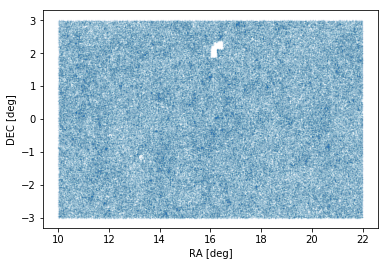

In [8]:
mtl_data = Table.read(mtlfile)
plt.scatter(mtl_data['RA'], mtl_data['DEC'],s=0.1, alpha=0.1)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [9]:
# compute sky file
def write_initial_sky_file(sky_path, sky_filename, initial_sky_file):
    sky_data = Table.read(os.path.join(sky_path, sky_filename))
    subset_ii = (sky_data['RA']>10) &  (sky_data['RA']<22) & (sky_data['DEC']<3) & (sky_data['DEC']>-3)
    print('writing sky')
    sky_data[subset_ii].write(initial_sky_file, overwrite=True)
    print('done writing sky')

if (not os.path.exists(skycutfile)):
    write_initial_sky_file(paths["skies"], names["skies"], skycutfile)
skydata = Table.read(skycutfile)

writing sky
done writing sky


Text(0,0.5,'DEC [deg]')

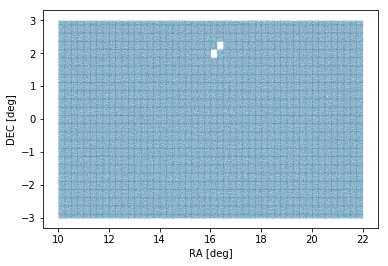

In [10]:
plt.scatter(skydata['RA'], skydata['DEC'],s=0.1, alpha=0.1)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [11]:
cmd = 'fiberassign --overwrite --mtl mtl.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)
print(cmd)

fiberassign --overwrite --mtl mtl.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/


In [12]:
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: fiberassign --overwrite --mtl mtl.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/
0


In [13]:
tiles = Table.read("tiles.fits")
targets = Table.read("mtl.fits")

Text(0,0.5,'DEC [deg]')

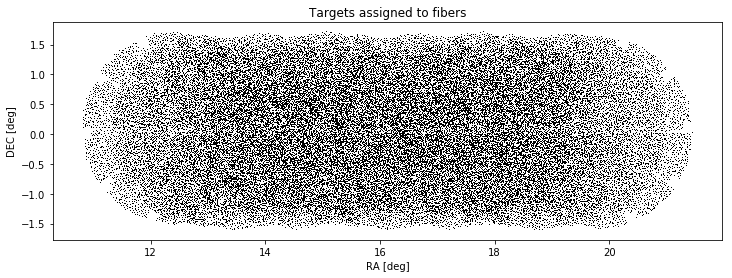

In [14]:
# Gather all outputs
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/fiberassign-{:06d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, hdu=1))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

plt.figure(figsize=(12,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

Text(0,0.5,'DEC [deg]')

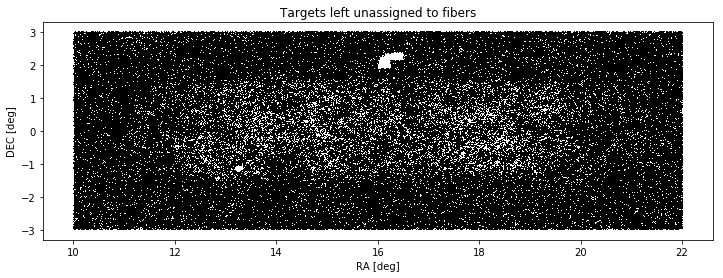

In [15]:
plt.figure(figsize=(12,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets left unassigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')